In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
PATH_OPERATE_POS = len(sys.path)
sys.path.append('.') 

### Для детекции используется yolov5 из https://github.com/ultralytics/yolov5.   
### Модель уже имеет очень хорошую оболочку на pytorch и готова к использованию (в том числе инференс на gpu). Так как цель - быстрый инференс - данная модель также подходит

### Модель предобучена на MS COCO

### Альтернативы
1. yolov4 - не нашел нормальных тестов, подтверждающих, что она лучше/хуже (и вышли они с интервалом в 2 месяца). Кроме того, есть хорошая реализация на tensorflow (https://github.com/hunglc007/tensorflow-yolov4-tflite)
2. Семейство SSD сетей. Раньше больше подходила под реальное время из-за большего FPS (и сравнительно малой просадки по точности по сравнению с соответствующими моделями yolo)

Также проконсультиоовался с другом из CV (~middle). Он использует SSD, говорит, что существенной разницы возникнуть не должно, однако у yolo версии обновились и выглядят препочтительнее


In [3]:
DATA_PATH = 'drive/MyDrive/DataSet_fishes'

In [4]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 8338, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 8338 (delta 24), reused 23 (delta 13), pack-reused 8288
Receiving objects: 100% (8338/8338), 9.21 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (5766/5766), done.
     |████████████████████████████████| 636 kB 27.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!ls yolov5

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  utils
data		 export.py   models	train.py	  val.py
detect.py	 hubconf.py  README.md	tutorial.ipynb


# Transfer learning

In [12]:
!pip install wandb --quiet
import wandb
wandb.init()

     |████████████████████████████████| 1.8 MB 30.7 MB/s 
     |████████████████████████████████| 133 kB 68.8 MB/s 
     |████████████████████████████████| 138 kB 70.5 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 170 kB 64.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



### Возьмем для примера небольшой датасет с детекцией рыб разных видов
### Для чистоты датасет был скачан в формате coco и вручную переведен в формат yolo

In [ ]:
#!git clone https://github.com/ultralytics/JSON2YOLO.git
#!pip install -r ./JSON2YOLO/requirements.txt

Cloning into 'JSON2YOLO'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 258 (delta 48), reused 49 (delta 19), pack-reused 172
Receiving objects: 100% (258/258), 66.85 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [ ]:
#sys.path[PATH_OPERATE_POS] = './JSON2YOLO'

In [ ]:
#from JSON2YOLO import general_json2yolo

In [ ]:
!ls $DATA_PATH/

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
# Переформатирование данных

# !mkdir $DATA_PATH/train/images/
# !mv $DATA_PATH/train/*jpg $DATA_PATH/train/images/

# !mkdir $DATA_PATH/valid/images/
# !mv $DATA_PATH/valid/*jpg $DATA_PATH/valid/images/

# !mkdir $DATA_PATH/test/images/
# !mv $DATA_PATH/test/*jpg $DATA_PATH/test/images/

In [ ]:
# Конвертирование меток из .json coco в файлы .txt для yolo
# labels_save_path = 'new_dir/labels/_annotations.coco/*' # временный костыль

# !rm -r new_dir
# general_json2yolo.convert_coco_json(DATA_PATH + '/train')
# !mkdir $DATA_PATH/train/labels
# !mv $labels_save_path $DATA_PATH/train/labels/

# !rm -r new_dir
# general_json2yolo.convert_coco_json(DATA_PATH + '/valid')
# !mkdir $DATA_PATH/valid/labels
# !mv $labels_save_path $DATA_PATH/valid/labels/

# !rm -r new_dir
# general_json2yolo.convert_coco_json(DATA_PATH + '/test')
# !mkdir $DATA_PATH/test/labels
# !mv $labels_save_path $DATA_PATH/test/labels/

Annotations /content/drive/MyDrive/DataSet_fishes/train/_annotations.coco.json: 100%|██████████| 3324/3324 [00:00<00:00, 10396.01it/s]


mkdir: cannot create directory ‘drive/MyDrive/DataSet_fishes/train/labels’: File exists


Annotations /content/drive/MyDrive/DataSet_fishes/valid/_annotations.coco.json: 100%|██████████| 909/909 [00:00<00:00, 10021.77it/s]
Annotations /content/drive/MyDrive/DataSet_fishes/test/_annotations.coco.json: 100%|██████████| 584/584 [00:00<00:00, 10186.28it/s]


In [6]:
# create config file

config_file = (
    f"""
    path: ../{DATA_PATH}
    train: train/images
    val: valid/images
    test: test/images

    nc: 8
    names: ['creatures', 'fish', 'jellyfish', 'penguin', 
            'puffin', 'shark', 'starfish', 'stingray']
    """
)

with open('yolov5/data/fish_config.yaml', 'w+') as f:
  f.writelines(config_file)


In [5]:
%cd yolov5

/content/yolov5


In [9]:
!ls ../drive/MyDrive/DataSet_fishes

coco_val2017_part    test		       valid		yolov5s_base.pt
README.dataset.txt   train		       yolov5m_base.pt
README.roboflow.txt  train_freeze_backbone.py  yolov5s_base


In [39]:
# правленный скрипт для обучения с замороженными слоями
!scp ../drive/MyDrive/DataSet_fishes/train_freeze_backbone.py .

In [13]:
!python train_freeze_backbone.py --img 640 --batch 16 --epochs 50 --data fish_config.yaml --weights yolov5m.pt

train: weights=yolov5m.pt, cfg=, data=fish_config.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-304-g2c073cd torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, pers

In [ ]:
!ls runs/train/exp3

confusion_matrix.png				    results.txt
events.out.tfevents.1626866055.3eb37e92668b.2582.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.png					    weights


In [15]:
import skimage.io as io
import matplotlib.pyplot as plt

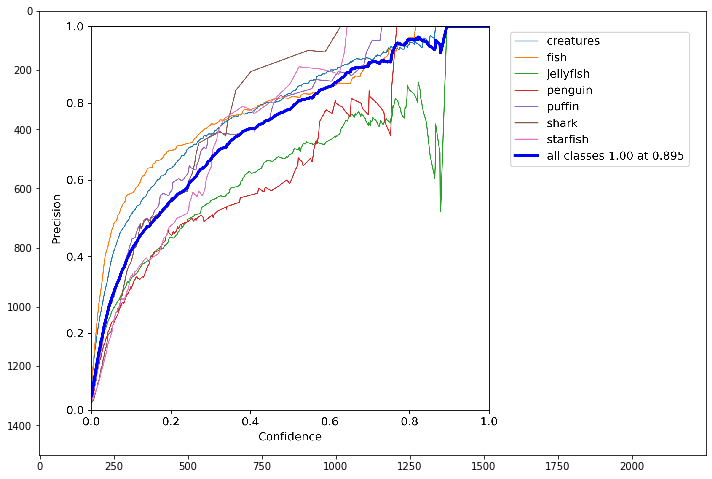

In [18]:
res = io.imread('runs/train/exp2/P_curve.png')

plt.figure(figsize = (10,10))
io.imshow(res)

In [39]:
res = io.imread('runs/train/exp/P_curve.png')

plt.figure(figsize = (10,10))
io.imshow(res, interpolation='nearest', aspect='auto')

In [ ]:
img_true = io.imread('runs/train/exp/val_batch1_labels.jpg')


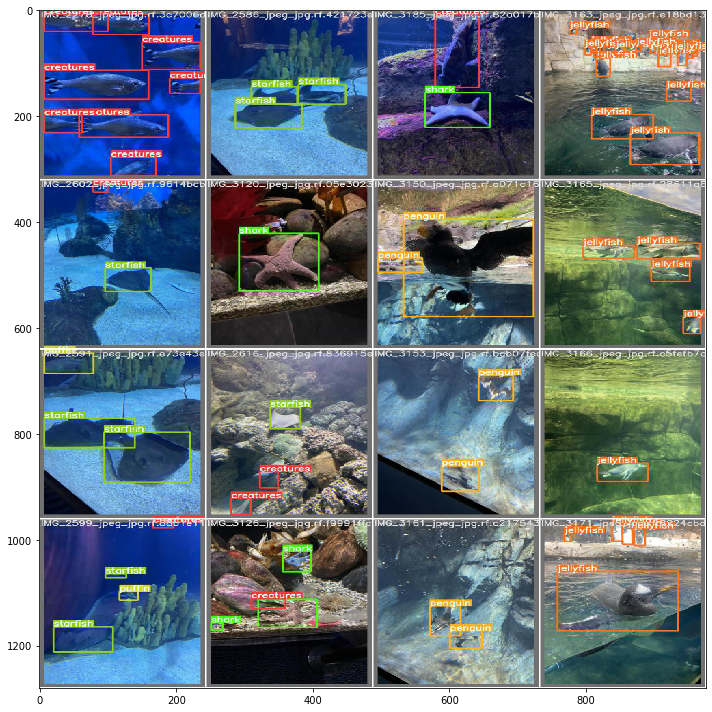

In [ ]:
plt.figure(figsize = (10,10))
io.imshow(img_true, interpolation='nearest', aspect='auto')

In [ ]:
img = io.imread('runs/train/exp/val_batch1_pred.jpg')

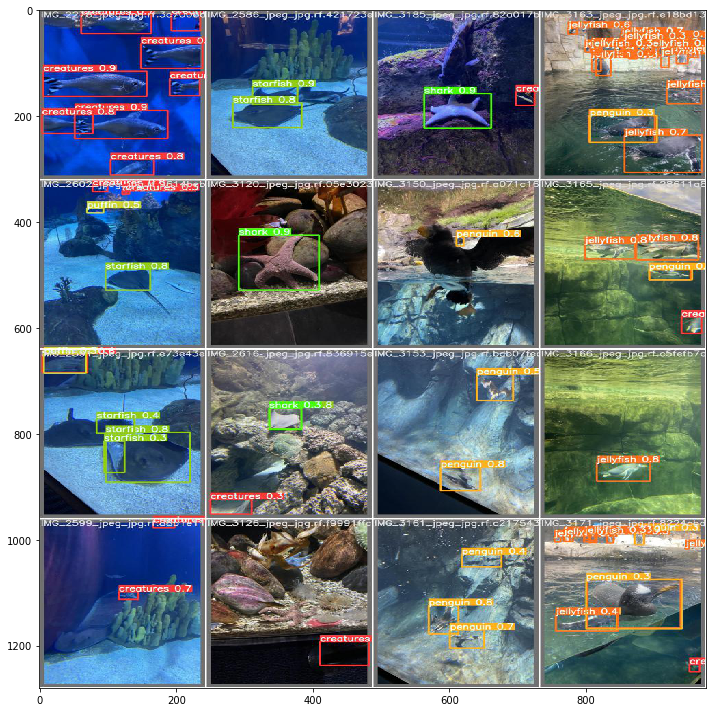

In [ ]:
plt.figure(figsize = (10,10))
io.imshow(img, interpolation='nearest', aspect='auto')

In [ ]:
!ls runs/train/exp/weights

best.pt  last.pt


In [19]:
!scp -r runs/train/exp2 /content/drive/MyDrive/DataSet_fishes/yolov5m_base

# Model pruning

В данном случае не дал существенного прироста к скорости инференса. При этом снижение точности очень заметно

In [ ]:
from models.experimental import attempt_load

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from copy import deepcopy

In [ ]:
!ls

CONTRIBUTING.md  LICENSE	   utils
data		 models		   val.py
detect.py	 README.md	   yolov5s_base.mlmodel
Dockerfile	 requirements.txt  yolov5s_base.onnx
export.py	 train.py	   yolov5s_base.pt
hubconf.py	 tutorial.ipynb    yolov5s_base.torchscript.pt


In [ ]:
model = attempt_load('yolov5s_base.pt', map_location='cpu')  # load FP32 model

In [ ]:
device = 'cpu'
ckpt = torch.load('yolov5s_base.pt', device) 
model = ckpt['model']

In [ ]:
c2d = 0
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    c2d+=1

In [ ]:
c2d

62

In [ ]:
count = 0
for name, module in model.named_modules():
    
    if isinstance(module, torch.nn.Conv2d):
        count+=1
        if count < 60:
          continue
        #print('c2d')
        prune.random_unstructured(module, name='weight', amount=0.1)
        prune.remove(module, 'weight') # make it permanent


In [ ]:
def is_parallel(model):
    # Returns True if model is of type DP or DDP
    return type(model) in (nn.parallel.DataParallel, nn.parallel.DistributedDataParallel)


def de_parallel(model):
    # De-parallelize a model: returns single-GPU model if model is of type DP or DDP
    return model.module if is_parallel(model) else model

In [ ]:
ckpt['model'] = deepcopy(de_parallel(model))
#deepcopy(de_parallel(model)).half(),

In [ ]:
torch.save(ckpt, './yolov5s_base_pruned.pt')

# Сравним время инференса

In [ ]:
%cd yolov5

/content/yolov5


In [6]:
!scp  /content/drive/MyDrive/DataSet_fishes/yolov5s_base.pt .

In [7]:
!ls 

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  utils
data		 export.py   models	train.py	  val.py
detect.py	 hubconf.py  README.md	tutorial.ipynb	  yolov5s_base.pt


In [8]:
!pip install coremltools

     |████████████████████████████████| 3.4 MB 34.1 MB/s 
  Created wheel for attr: filename=attr-0.3.1-py3-none-any.whl size=2457 sha256=d36bc0dd73d4e6a02cadfe402934a12641ce5eb4a43742577b197a28a9d1236b
  Stored in directory: /root/.cache/pip/wheels/3b/5d/58/41fbe92f47031641008bd8559ee89e58bf0f123f9c18dea1cb
Successfully built attr


### Экспортируем в onnx, чтобы запустить позже на triton inferense server

In [37]:
!python export.py --weights ./yolov5s_base_pruned.pt --img 480 --batch 1 

export: weights=./yolov5s_base_pruned.pt, img_size=[480], batch_size=1, device=cpu, include=['torchscript', 'onnx', 'coreml'], half=False, inplace=False, train=False, optimize=False, dynamic=False, simplify=False, opset_version=12
YOLOv5 🚀 v5.0-305-g4bad914 torch 1.9.0+cu102 CPU

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7072789 parameters, 0 gradients, 16.4 GFLOPs

PyTorch: starting from ./yolov5s_base_pruned.pt (14.4 MB)

TorchScript: starting export with torch 1.9.0+cu102...
/content/yolov5/models/yolo.py:57: TracerWarning: Converting a tensor to a Python boolean might cause the trac

In [10]:
!ls

CONTRIBUTING.md  LICENSE	   utils
data		 models		   val.py
detect.py	 README.md	   yolov5s_base.mlmodel
Dockerfile	 requirements.txt  yolov5s_base.onnx
export.py	 train.py	   yolov5s_base.pt
hubconf.py	 tutorial.ipynb    yolov5s_base.torchscript.pt


In [38]:
!scp yolov5s_base_pruned.onnx /content/drive/MyDrive/DataSet_fishes/yolov5s_base_pruned.onnx

#### Базовая конфигурация

In [ ]:
# GPU util 25%
# Memory GPU 4.5 GB

!python val.py --weights yolov5m_base.pt --data fish_config.yaml --img 640 --batch-size 1 --task test

val: data=./data/fish_config.yaml, weights=['yolov5m_base.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21065925 parameters, 0 gradients, 50.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missing, 0 e

#### Квантизация 32 bit -> 16 bit

In [ ]:
# GPU util 25%
# Memory GPU 4.2 GB

!python val.py --weights yolov5m_base.pt --data fish_config.yaml --img 640 --batch-size 1 --task test --half 

val: data=./data/fish_config.yaml, weights=['yolov5m_base.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21065925 parameters, 0 gradients, 50.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missing, 0 em

#### Размер изображения 640 -> 480

In [ ]:
# GPU util 15%
# Memory GPU 3.8 GB

!python val.py --weights yolov5m_base.pt --data fish_config.yaml --img 480 --batch-size 1 --task test --half 

val: data=./data/fish_config.yaml, weights=['yolov5m_base.pt'], batch_size=1, imgsz=480, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21065925 parameters, 0 gradients, 50.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missing, 0 em

#### Прунинг весов (не успешен, т.к. коэфицент мал и это не дает преимуществ от разреженности)

In [ ]:
# GPU util 24%
# Memory GPU 4.3 GB

!python val.py --weights yolov5m_base_pruned.pt --data fish_config.yaml --img 640 --batch-size 1 --task test

val: data=./data/fish_config.yaml, weights=['yolov5m_base_pruned.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21065925 parameters, 0 gradients, 50.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missi

#### Использование младшей архитектуры. M -> S

In [ ]:
!python val.py --weights yolov5s_base.pt --data fish_config.yaml --img 640 --batch-size 1 --task test

val: data=./data/fish_config.yaml, weights=['yolov5s_base.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7072789 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missing, 0 em

#### Младшая архитектура + квантизация

In [ ]:
!python val.py --weights yolov5s_base.pt --data fish_config.yaml --img 640 --batch-size 1 --task test --half

val: data=./data/fish_config.yaml, weights=['yolov5s_base.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7072789 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning '../drive/MyDrive/DataSet_fishes/test/labels.cache' images and labels... 63 found, 0 missing, 0 emp